Métricas (Média de previsões recursivas 24h à frente no conjunto de teste):
MAPE: 0.0778
MSE: 113005.8721
MAE: 219.6512


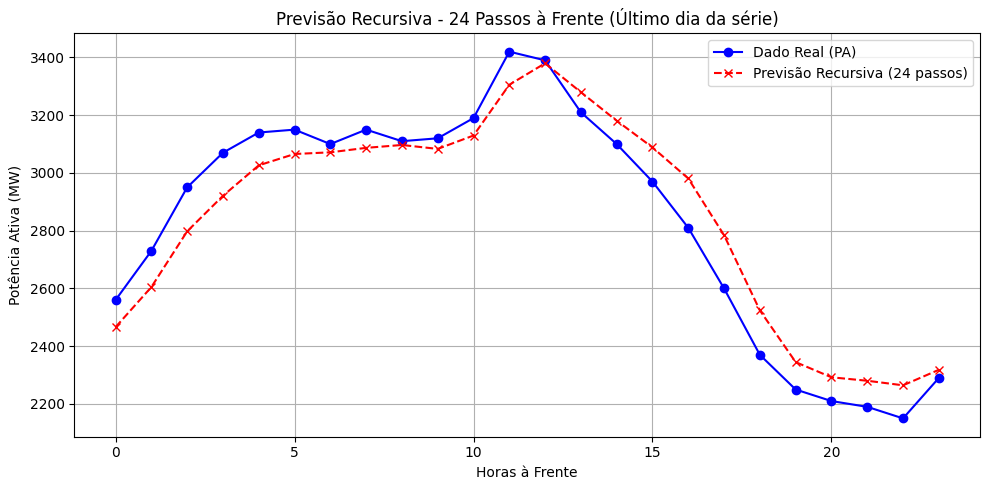

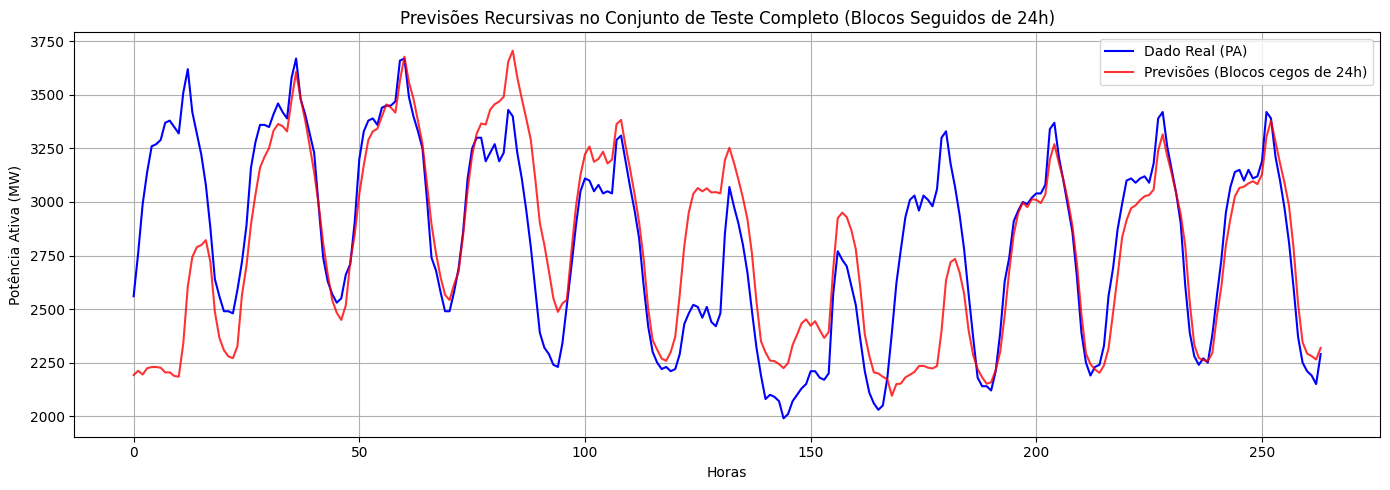

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 1. Carregar Dados
# Certifique-se de que o arquivo CSV extraído do Excel está na mesma pasta
df = pd.read_excel('carga_eletrica.xlsx') # Changed to read_excel and updated filename
data = df['PA(MW)'].values.reshape(-1, 1)

# 2. Normalização dos Dados
# Redes neurais se beneficiam fortemente de dados em uma escala reduzida (0 a 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 3. Divisão Inicial (70% Treino e 30% Teste)
n_total = len(data)
train_size = int(0.70 * n_total)
test_size = n_total - train_size

# 4. Formatação de Entradas e Saídas: k-1, k-2, k-24 para prever a saída k
X, y = [], []
for k in range(24, n_total):
    X.append([data_scaled[k-1, 0], data_scaled[k-2, 0], data_scaled[k-24, 0]])
    y.append(data_scaled[k, 0])

X = np.array(X)
y = np.array(y)

# Separar os conjuntos com base no índice de divisão
# OBS: O dataset "X" começa na hora 24, por isso removemos 24 do índice de corte
split_idx = train_size - 24
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

# 5. Criação e Treinamento do Previsor Neural (MLP)
# Utilizamos 2 camadas ocultas com 20 e 10 neurônios, respectivamente
model = MLPRegressor(hidden_layer_sizes=(20, 10), activation='relu', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# 6. Teste-Cego e Previsão Recursiva no Conjunto de Teste
# Faremos janelas de 24 passos ao longo de todo o conjunto de testes
mapes, mses, maes = [], [], []
all_preds_mw, all_true_mw = [], []

# O teste varrerá a base a cada 24 horas
test_starts = range(train_size, n_total, 24)

for start in test_starts:
    # Caso a última janela seja menor do que 24h, encerra o loop
    if start + 24 > n_total:
        break

    # "Fotografia" das últimas 24 horas para dar suporte ao primeiro passo
    history = list(data_scaled[start-24 : start, 0])
    preds_scaled = []

    # Realiza de forma recursiva a previsão de 1 até 24 passos à frente
    for step in range(24):
        # Entradas: PA(k-1), PA(k-2), PA(k-24) tiradas do histórico
        x_in = np.array([[history[-1], history[-2], history[-24]]])

        # Previsão
        pred = model.predict(x_in)[0]
        preds_scaled.append(pred)

        # Retroalimenta a predição atual no final do histórico,
        # para que ela vire o "k-1" do próximo passo
        history.append(pred)

    true_vals_scaled = data_scaled[start : start+24, 0]

    # Desfaz a normalização (retorna à escala original em MW) para calcular o erro
    preds_mw = scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    true_mw = scaler.inverse_transform(np.array(true_vals_scaled).reshape(-1, 1)).flatten()

    all_preds_mw.extend(preds_mw)
    all_true_mw.extend(true_mw)
    last_preds, last_true = preds_mw, true_mw

    # Salva as métricas para esta janela de 24 horas específica
    mapes.append(mean_absolute_percentage_error(true_mw, preds_mw))
    mses.append(mean_squared_error(true_mw, preds_mw))
    maes.append(mean_absolute_error(true_mw, preds_mw))

# 7. Exibição das Métricas Finais
print(f"Métricas (Média de previsões recursivas 24h à frente no conjunto de teste):")
print(f"MAPE: {np.mean(mapes):.4f}")
print(f"MSE: {np.mean(mses):.4f}")
print(f"MAE: {np.mean(maes):.4f}")

# 8. Gráficos Comparativos

# 8.1 - O último ciclo de teste de 24 horas isolado
plt.figure(figsize=(10, 5))
plt.plot(last_true, label='Dado Real (PA)', marker='o', color='blue')
plt.plot(last_preds, label='Previsão Recursiva (24 passos)', marker='x', color='red', linestyle='--')
plt.title("Previsão Recursiva - 24 Passos à Frente (Último dia da série)")
plt.xlabel("Horas à Frente")
plt.ylabel("Potência Ativa (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8.2 - Teste contínuo (todas as janelas de 24h previstas seguidamente)
plt.figure(figsize=(14, 5))
plt.plot(all_true_mw, label='Dado Real (PA)', color='blue')
plt.plot(all_preds_mw, label='Previsões (Blocos cegos de 24h)', color='red', alpha=0.8)
plt.title("Previsões Recursivas no Conjunto de Teste Completo (Blocos Seguidos de 24h)")
plt.xlabel("Horas")
plt.ylabel("Potência Ativa (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()